## Step 0. Imports and Constants

In [1]:
# install packages
!pip install -U torch torchvision
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg
!pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
!pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 870.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 26.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires torch<1.12.0,>=1.10.0, but you have torch 1.12.1 which is incompatible.
allennlp 2.10.0 requires torchvision<0.13.0,>=0.8.1, but you have torchvision 0.13.1 which is incompatible.
     ━━━━━━━━━━━━

In [2]:
# import libraries
import os
import cv2
import pylibjpeg
import numpy as np
import pandas as pd
import pydicom as dicom
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import torch
import torchvision as tv
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# specify paths and parameters
PATH_MAIN = '../input/rsna-2022-spine-fracture-detection-metadata'  # to be changed
PATH_SEGMENTATION = f'{PATH_MAIN}/meta_segmentation.csv'
PATH_TRAIN_IMAGES = '../input/rsna-2022-cervical-spine-fracture-detection/train_images'

NUM_VERTEBRAE = 7
NUM_FOLDS = 5
BATCH_SIZE = 32

In [4]:
# use PyTorch CUDA for computation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda


## Step 1. Load Data

In [5]:
def load_image(image_path):
    '''
    Load image data from given path. Return the image pixel array and the file metadata.
    
    Parameters:
        image_path: str
            Path to the dicom file of the target image.
    
    Return:
        image: numpy.ndarray
            The image pixel array with shape (H, W, C) in which C = 3 (RGB image).
            Pixel values range from 0 to 255.
        metadata: pydicom.dataset.FileDataset
            The metadata of the dicom file.
    '''
    # load metadata and alter photometric interpretation of image pixels
    metadata = dicom.dcmread(image_path)
    # extract image pixel array and rescale to [0, 255]
    image = metadata.pixel_array
    image = 255 * ((image - np.min(image)) / (np.max(image) - np.min(image)))
    # change image dtype and convert to RGB
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image, metadata

image shape: (512, 512, 3)
pixel range: [0, 255]


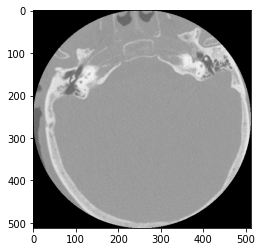

In [6]:
# load an image
image, metadata = load_image(f'{PATH_TRAIN_IMAGES}/1.2.826.0.1.3680043.17625/1.dcm')
print(f'image shape: {image.shape}')
print(f'pixel range: [{np.min(image)}, {np.max(image)}]')
plt.imshow(image)
plt.show()

In [7]:
# load vertebrae segmentation dataset
df_segmentation = pd.read_csv(PATH_SEGMENTATION)
df_segmentation.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.0,98.0,312.599976,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.0,98.0,312.099976,0,0,0,0,0,0,0


In [8]:
# split the dataset into folds by Group K-Fold mechanism
# ensure that the slices from the same patient do not appear in training and test set simultaneously
group_kfold = GroupKFold(NUM_FOLDS)
folds = group_kfold.split(df_segmentation, groups=df_segmentation.StudyInstanceUID)
for fold, (_, test_indices) in enumerate(folds):
    df_segmentation.loc[test_indices, 'Fold'] = fold
df_segmentation.iloc[:,-1] = df_segmentation.iloc[:,-1].astype(np.uint8)
print(f'fold indices: {sorted(df_segmentation.Fold.unique())}')
df_segmentation.sample(5)

fold indices: [0, 1, 2, 3, 4]


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,Fold
15007,1.2.826.0.1.3680043.26442,230,512,512,0.625,-85.000000,-33.300000,-193.125,0,0,0,1,1,0,0,1
21699,1.2.826.0.1.3680043.3168,143,512,512,1.000,-85.826172,-285.826172,-435.500,0,0,0,0,0,0,1,4
19638,1.2.826.0.1.3680043.30067,36,512,512,1.000,-66.331055,-228.331055,-128.000,0,0,0,0,0,0,0,4
23794,1.2.826.0.1.3680043.3376,60,512,512,0.500,-79.875900,-91.594700,-471.100,1,1,0,0,0,0,0,2
28148,1.2.826.0.1.3680043.780,20,512,512,1.000,-70.350586,-205.850586,132.000,0,0,0,0,0,0,0,2


In [9]:
# add another column to dataframe: SliceRatio
# SliceRatio specifies the ratio of the current slice 
# with respect to the total number of slices of this patient
# i.e., SliceRatio = current slice index / max slice index

# create a dictionary which maps each StudyInstanceUID (patient)
# to the total number of slices of this patient
uid2max_slice = df_segmentation.groupby('StudyInstanceUID')['Slice'].max().to_dict()
max_slices = df_segmentation['StudyInstanceUID'].map(uid2max_slice)
df_segmentation['SliceRatio'] = df_segmentation['Slice'] / max_slices
df_segmentation.sample(5)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,Fold,SliceRatio
13663,1.2.826.0.1.3680043.25833,276,512,512,0.625,-121.200000,-121.500000,-194.875,0,0,0,0,0,0,0,4,0.818991
24904,1.2.826.0.1.3680043.4202,24,512,512,1.000,-76.730900,-72.980960,-517.900,0,0,0,0,0,0,0,1,0.087912
28175,1.2.826.0.1.3680043.780,47,512,512,1.000,-70.350586,-205.850586,105.000,0,0,0,0,0,0,0,2,0.241026
7086,1.2.826.0.1.3680043.18906,259,512,512,1.000,-72.362300,-282.362300,-310.700,0,0,0,0,0,0,1,3,0.737892
22738,1.2.826.0.1.3680043.32434,226,512,512,1.000,-129.132000,-116.007000,-613.000,0,0,0,0,0,1,1,4,0.649425


In [10]:
class ImageDataset(torch.utils.data.Dataset):
    '''
    An image dataset to extract slice images and their target labels
    '''
    def __init__(self, df, image_dir):
        '''
        Initialize the image dataset.
        
        Parameters:
            df: pandas.core.frame.DataFrame
                The dataframe containing segmentation information of each slice.
            image_dir: str
                The path to the image directory.
        '''
        super().__init__()
        self.df = df
        self.image_dir = image_dir
    
    def __len__(self):
        '''
        Length of the dataset
        
        Return:
            length: int
                Total number of slices in the dataset.
        '''
        length = len(self.df)
        return length
    
    def __getitem__(self, idx):
        '''
        Retrieve the idx-th slice of the dataset and its corresponding vertebrae labels.
        
        Parameters:
            idx: int
                The index of the slice in the dataset to retrieve.
        
        Return:
            image: torch.Tensor
                The tensor of slice image pixels in the shape of [C, H, W].
            labels: torch.Tensor
                The tensor of target vertebrae labels of the image in the shape of [NUM_VERTEBRAE].
                The i-th entry of this tensor is either 0 or 1, 
                indicating whether the vertebrae Ci is in this slice or not.
                Return random numbers if df does not have vertebrae label columns.
        '''
        # get path to the slice image
        patient_uid = self.df.iloc[idx].StudyInstanceUID
        slice_number = self.df.iloc[idx].Slice
        image_path = os.path.join(self.image_dir, patient_uid, f'{slice_number}.dcm')
        # load the slice image
        image, _ = load_image(image_path)
        # convert (H, W, C) to (C, H, W) in the PyTorch convention
        image = np.transpose(image, (2, 0, 1))
        # transform the image
        image = torch.as_tensor(image)
        
        # retrieve image labels if the dataframe has label columns
        labels = torch.randn(NUM_VERTEBRAE)
        if 'C1' in self.df.columns:
            # get column names of the vertebrae labels to retrieve
            cols = [f'C{i}' for i in range(1, NUM_VERTEBRAE+1)]
            # get the labels
            labels = self.df.iloc[idx][cols]
            # transform the labels
            labels = labels.astype(np.float64)
            labels = torch.as_tensor(labels)
        return image, labels

In [11]:
# check image and labels retrieved from dataset
ds_segmentation = ImageDataset(df_segmentation, PATH_TRAIN_IMAGES)
image, labels = ds_segmentation[612]
C, H, W = image.shape
print(f'image shape: {image.shape}')
print(f'labels: {labels}')

image shape: torch.Size([3, 512, 512])
labels: tensor([0., 0., 0., 0., 1., 1., 0.], dtype=torch.float64)


## Step 2. Model Construction

In [12]:
class Model(torch.nn.Module):
    '''
    A vertebrae detection model.
    '''
    def __init__(self, model, transform=None):
        '''
        Model initialization.
        
        Parameters:
            model: torchvision.models
                The feature extraction model to get the image features.
            transform: torchvision.transforms._presets.ImageClassification, default=None
                The transformation applied on the images.
        '''
        super().__init__()
        # image transformation procedures
        self.transform = transform
        # get flatten layer output, i.e., feature vector of the slice image
        self.model = create_feature_extractor(
            model,
            ['flatten']
        )
        # input dimension of the fully connected layer
        fc_input_dim = self.model(self.transform(torch.randn(1, C, H, W)))['flatten'].shape[1]
        # fully connected layer to get the final prediction vector
        self.fc = torch.nn.Linear(fc_input_dim, NUM_VERTEBRAE)

    def forward(self, x):
        '''
        Predict the probability logit of each vertebra being present in the image.
        
        Parameters:
            x: torch.Tensor
                The input image tensor of shape [B, C, H, W].
        
        Return:
            out: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the vertebrae probability logits.
        '''
        x = self.transform(x)
        x = self.model(x)['flatten']  # shape [B, fc_input_dim]
        out = self.fc(x)  # shape [B, NUM_VERTEBRAE]
        return out
    
    def predict(self, x):
        '''
        Predict the probabilities of each vertebra being present in the image.
        
        Parameters:
            x: torch.Tensor
                The input image tensor of shape [B, C, H, W].
        
        Return:
            probabilities: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the vertebrae probabilities.
        '''
        logits = self.forward(x)
        probabilities = torch.nn.Sigmoid()(logits)
        return probabilities

## Step 3. Model Training and Evaluation

In [13]:
def evaluate(model, ds):
    '''
    Evaluate the model performance on the test set.
    
    Parameters:
        model: Model
            The model to test performance.
        ds: ImageDataset
            The test image dataset.
    
    Return:
        accuracy: float
            The prediction accuracy of the model on the given test dataset.
        preds: numpy.ndarray
            The predicted probability result of all test slices, 
            with shape [N, NUM_VERTEBRAE] where N is the number of test samples.
    '''
    # load the test dataset
    test_dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count()
    )
    # use GPU for acceleration
    model = model.to(DEVICE)
    
    # disable gradient calculation
    with torch.no_grad():
        # lists of predicted and true vertebrae labels
        preds, trues = [], []
        # evaluation mode
        model.eval()
        # make predictions for each batch
        # image shape: [B, C, H, W]
        # labels shape: [B, NUM_VERTEBRAE]
        for image, labels in tqdm(test_dataloader, desc='Evaluation'):
            # cast tensors to a smaller memory footprint to save memory
            with torch.cuda.amp.autocast():
                # make predictions
                pred = model.predict(image.to(DEVICE))
            # store the true and predicted labels to lists
            preds.append(pred.cpu().numpy())
            trues.append(labels.numpy())
        
        # concatenate predicted and true labels of all the batches
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        # calculate the overall prediction accuracy (threshold 0.5)
        accuracy = np.mean((preds > 0.5) == trues)
        print(f'Evaluation accuracy: {accuracy}')
        
    return accuracy, preds

In [14]:
def train(model, ds_train, ds_test=None):
    '''
    Train the model by the training set and evaluate its performance on the test set.
    
    Parameters:
        model: Model
            The model to train and test performance.
        ds_train: ImageDataset
            The training dataset.
        ds_test: ImageDataset, default=None
            The test dataset to evaluate the model performance.
            If not specified, do not conduct model evaluation.
            
    Return:
        test_accuracy: float
            The prediction accuracy of the model on the test dataset.
            Return None if test set not specified.
        preds: numpy.ndarray
            The predicted probability result of all test slices, 
            with shape [N, NUM_VERTEBRAE] where N is the number of test samples.
            Return None if test set not specified.
    '''
    # load the training dataset
    train_dataloader = torch.utils.data.DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count()
    )
    # prepare model, optimizer, and scheduler
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=0.0004, 
        epochs=1, 
        steps_per_epoch=len(train_dataloader), 
        pct_start=0.3
    )

    # train mode
    model.train()
    # use gradient scaler to avoid underflowing gradients
    scaler = torch.cuda.amp.GradScaler()
    # update the weights using each batch
    # image shape: [B, C, H, W]
    # labels shape: [B, NUM_VERTEBRAE]
    for image, labels in tqdm(train_dataloader, desc='Train'):
        # start from zero gradients
        optimizer.zero_grad()
        # cast tensors to a smaller memory footprint to save memory
        with torch.cuda.amp.autocast():
            # make predictions and get logits
            pred = model.forward(image.to(DEVICE))
            # compute the binary cross entropy loss between target and predicted logits
            true = labels.to(DEVICE)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, true)
        
        # update weights by backward propagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # update the scheduler
        scheduler.step()

    # evaluate the trained model, get test accuracy and prediction
    test_accuracy, preds = None, None
    if ds_test:
        test_accuracy, preds = evaluate(model, ds_test)
        
    return test_accuracy, preds

In [16]:
# perform K-fold cross validation
test_accs = []
for fold in range(NUM_FOLDS):
    # initialize the model
    weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT
    model = tv.models.efficientnet_v2_s(weights=weights)
    model = Model(model, transform=weights.transforms())
    # load the training set
    ds_train = ImageDataset(df_segmentation[df_segmentation.Fold != fold], PATH_TRAIN_IMAGES)
    # load the test set
    ds_test = ImageDataset(df_segmentation[df_segmentation.Fold == fold], PATH_TRAIN_IMAGES)
    # train and evaluate the model
    test_acc, _ = train(model, ds_train, ds_test)
    test_accs.append(test_acc)
    # clean cache
    torch.cuda.empty_cache()

print(f'Average test accuracy: {sum(test_accs) / NUM_FOLDS}')

Evaluation: 100%|██████████| 185/185 [00:58<00:00,  3.14it/s]


Evaluation accuracy: 0.9699324569685526


Evaluation: 100%|██████████| 190/190 [01:09<00:00,  2.72it/s]


Evaluation accuracy: 0.9532218895150072


Evaluation: 100%|██████████| 185/185 [01:06<00:00,  2.78it/s]


Evaluation accuracy: 0.9481750060430264


Evaluation: 100%|██████████| 185/185 [00:54<00:00,  3.38it/s]


Evaluation accuracy: 0.9194238344974262


Evaluation: 100%|██████████| 190/190 [01:03<00:00,  3.00it/s]


Evaluation accuracy: 0.9762258894633709
Average test accuracy: 0.9533958152974767


## Step 4. Inference

In [17]:
# initialize the model
weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT
model = tv.models.efficientnet_v2_s(weights=weights)
model = Model(model, transform=weights.transforms())
# load the training set (the entire segmentation dataset)
ds_train = ImageDataset(df_segmentation, PATH_TRAIN_IMAGES)
# train the model by the entire segmentation dataset
train(model, ds_train)

Train: 100%|██████████| 933/933 [09:28<00:00,  1.64it/s]


(None, None)

In [18]:
def infer(model, df, image_dir):
    '''
    Infer the vertebrae probabilities for all the slice samples in the given dataframe.
    
    Parameters:
        model: Model
            The model used for inference.
        df: pandas.core.frame.DataFrame
            The dataframe containing patient and slice indices to infer vertebrae.
        image_dir: str
            The path to the slice image directory.
    
    Return:
        preds: numpy.ndarray
            The predicted probability result of all test slices, 
            with shape [N, NUM_VERTEBRAE] where N is the total number of slices in df.
    '''
    ds = ImageDataset(df, PATH_TRAIN_IMAGES)
    dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=os.cpu_count()
    )
    # the final prediction results
    preds = []
    # use GPU for acceleration
    model = model.to(DEVICE)
    # disable gradient calculation
    with torch.no_grad():
        # evaluation mode
        model.eval()
        # make predictions for each image
        # image shape: [B, C, H, W]
        for image, _ in tqdm(dataloader, desc='Inference'):
            # cast tensors to a smaller memory footprint to save memory
            with torch.cuda.amp.autocast():
                # make predictions
                pred = model.predict(image.to(DEVICE))
            # store the true and predicted labels to lists
            preds.append(pred.cpu().numpy())
        # concatenate predicted and true labels of all the batches
        preds = np.concatenate(preds)
    return preds

In [19]:
# make inference for all the training sample slices
# to check the inference function is working properly
preds = infer(model, df_segmentation, image_dir=PATH_TRAIN_IMAGES)
# calculate all the predicted vertebrae probabilities
pred_cols = [f'C{i}_pred' for i in range(1, NUM_VERTEBRAE+1)]
df_segmentation[pred_cols] = preds
df_segmentation.head()

Inference: 100%|██████████| 933/933 [04:52<00:00,  3.19it/s]


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C7,Fold,SliceRatio,C1_pred,C2_pred,C3_pred,C4_pred,C5_pred,C6_pred,C7_pred
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,...,0,0,0.002331,0.001525,0.002705,0.004593,0.000789,0.000408,0.000278,0.000287
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,...,0,0,0.004662,0.001335,0.002705,0.004627,0.000710,0.000354,0.000276,0.000333
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,...,0,0,0.006993,0.001574,0.003052,0.004719,0.000730,0.000346,0.000269,0.000367
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.0,98.0,312.599976,0,0,...,0,0,0.009324,0.001450,0.002811,0.004265,0.000667,0.000330,0.000274,0.000389
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.0,98.0,312.099976,0,0,...,0,0,0.011655,0.001202,0.002165,0.003483,0.000524,0.000294,0.000274,0.000412


In [20]:
# check the accuracy on the training set 
# to ensure the inference function is working properly
cols = [f'C{i}' for i in range(1, NUM_VERTEBRAE+1)]
trues = df_segmentation[cols].values
preds = df_segmentation[pred_cols].values
accuracy = np.mean((preds > 0.5) == trues)
print(f'Training set accuracy: {accuracy}')

Training set accuracy: 0.9922853694977589


In [21]:
# infer the vertebrae probability for all the samples
df_all = pd.read_csv(os.path.join(PATH_MAIN, 'meta_train_clean.csv'))
df_all = df_all.head(100)  # extract 100 samples for testing, delete this line in the future
df_all.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782


In [22]:
# make inference for all the sample slices
preds = infer(model, df_all, image_dir=PATH_TRAIN_IMAGES)
# save all the predicted vertebrae probabilities
df_all[cols] = preds
df_all.to_csv('train_segmented.csv', index=False)
df_all.head()

Inference: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.002790,0.001629,0.001611,0.000280,0.000251,0.000395,0.000612
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.002621,0.001315,0.001124,0.000190,0.000238,0.000792,0.000985
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.002590,0.001495,0.001320,0.000182,0.000129,0.000208,0.000524
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.002800,0.001554,0.001300,0.000196,0.000157,0.000243,0.000667
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.002502,0.001410,0.001216,0.000166,0.000121,0.000255,0.000918
